<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [173]:
# MY CODE STARTS HERE
import numpy as np

# Check my data
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [174]:
print(df.shape)
df.dtypes

(421, 59)


Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [175]:
df.describe(include='object')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
count,421,421,26,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1
unique,5,169,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1
top,California,8/30/2016,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
freq,169,29,21,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1


In [176]:
df.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [177]:
df['Queso'].value_counts()

Series([], Name: Queso, dtype: int64)

In [0]:
# That's hilarious actually

# Alright, so I think I know how the ingredient columns work:
# they're marked with an x or an X if the ingredient is present,
# otherwise it's a NaN.
# I'll probably encode them myself as 0's for NaNs and 1's for x's
# I'll one hot encode the 'Burrito' column though

In [179]:
print(df.columns)
df.head()

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [180]:
df['Chips'].value_counts()

x      21
X       3
Yes     1
No      1
Name: Chips, dtype: int64

In [181]:
# Encoding the ingredient columns
df_to_encode = df.drop(['Burrito','Date','Yelp','Google','Cost','Hunger','Mass (g)',
                        'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
                        'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
                        'Synergy', 'Wrap','Great'], axis=1)
for col in df_to_encode.columns:
  df_to_encode[col] = df_to_encode[col].map({'x':1,'X':1,np.NaN:0,'Yes':1,'No':0})

df[df_to_encode.columns] = df_to_encode

df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,California,1/24/2016,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,Carnitas,1/24/2016,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,Asada,1/24/2016,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,California,1/27/2016,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


In [0]:
# Set date column to be a datetime format
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [183]:
# Train, Val, Test splits
train = df[df['Date'] < pd.to_datetime('2017-01-01')]
val = df[((df['Date'] < pd.to_datetime('2018-01-01')) & (df['Date'] >= pd.to_datetime('2017-01-01')))]
test = df[df['Date'] >= pd.to_datetime('2019-01-01')]

print(train.shape)
train.head()

(298, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,California,2016-01-24,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,Carnitas,2016-01-24,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,Asada,2016-01-24,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,California,2016-01-27,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


In [184]:
print(val.shape)
val.head()

(85, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,0,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
302,Other,2017-01-04,NaN,NaN,0,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
303,Other,2017-01-07,NaN,NaN,0,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
304,Other,2017-01-07,NaN,NaN,0,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
305,Other,2017-01-10,NaN,NaN,0,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [185]:
print(test.shape)
test.head()

(11, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,0,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
413,California,2019-08-24,NaN,NaN,0,8.00,4.0,NaN,NaN,NaN,NaN,NaN,4.0,4.5,3.5,4.0,4.0,5.0,4.7,4.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
414,Other,2019-08-27,NaN,NaN,0,5.50,2.0,NaN,NaN,19.00,23.0,0.80,4.5,5.0,5.0,3.5,4.0,4.5,4.0,4.9,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
415,Asada,2019-08-27,NaN,NaN,0,6.75,3.0,NaN,NaN,19.00,25.0,0.94,3.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
416,Other,2019-08-27,NaN,NaN,0,6.00,3.0,NaN,NaN,17.50,21.5,0.64,4.0,4.0,4.5,4.0,3.0,3.0,4.5,4.0,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True


In [0]:
# oh god not these again
import warnings
warnings.simplefilter('ignore')

# Set up features and target
features = df.drop(['Burrito','Date','Great'], axis=1).columns
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [187]:
# Encode 'Burrito'
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

print(X_train_encoded.shape)
X_train_encoded.head()

(298, 56)


,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
# Impute any missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

print(X_train_imputed.shape)
pd.DataFrame(X_train_imputed).head()

(298, 54)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,3.500000,4.200000,0.0,6.49,3.0,19.829886,22.042241,0.77092,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.500000,3.300000,0.0,5.45,3.5,19.829886,22.042241,0.77092,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.897183,4.142254,0.0,4.85,1.5,19.829886,22.042241,0.77092,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.897183,4.142254,0.0,5.25,2.0,19.829886,22.042241,0.77092,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.000000,3.800000,1.0,6.59,4.0,19.829886,22.042241,0.77092,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation Accuracy: 81.18%


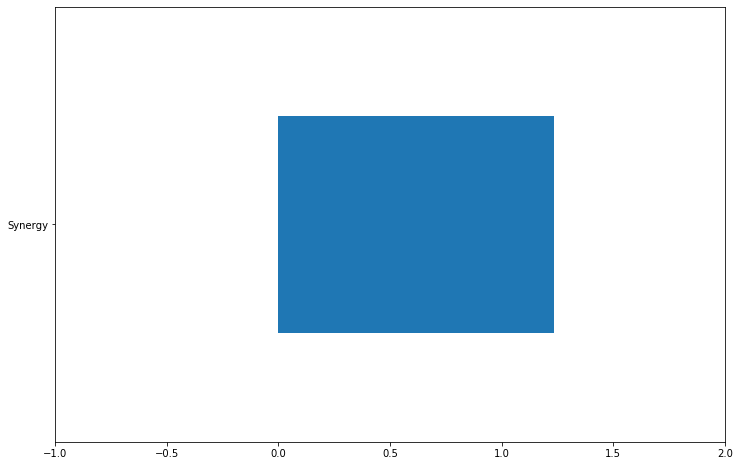

Validation Accuracy: 83.53%


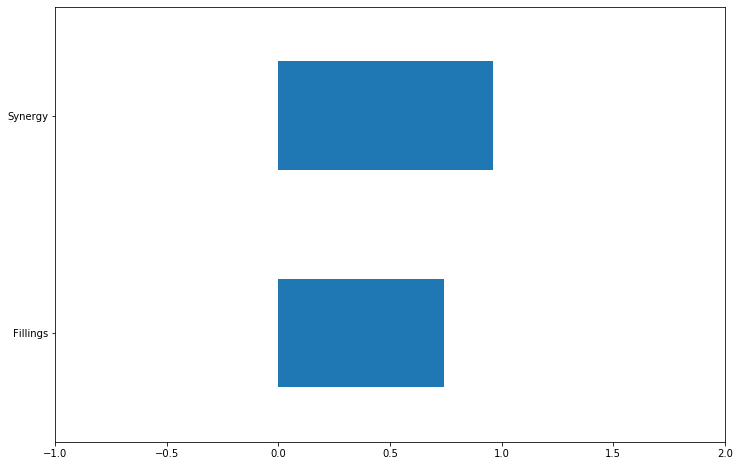

Validation Accuracy: 91.76%


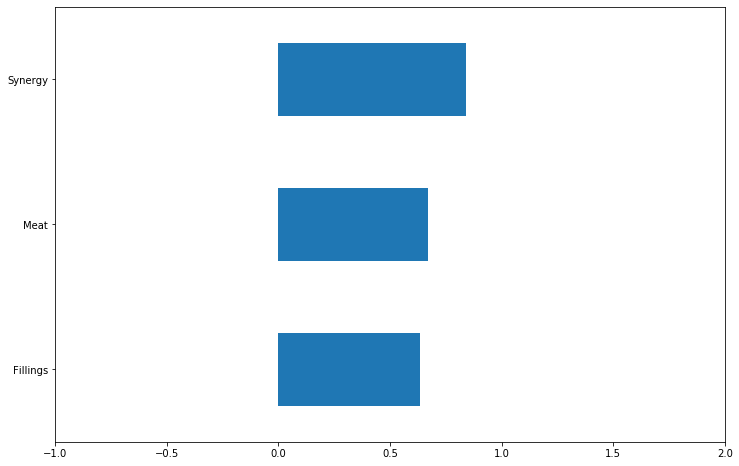

Validation Accuracy: 87.06%


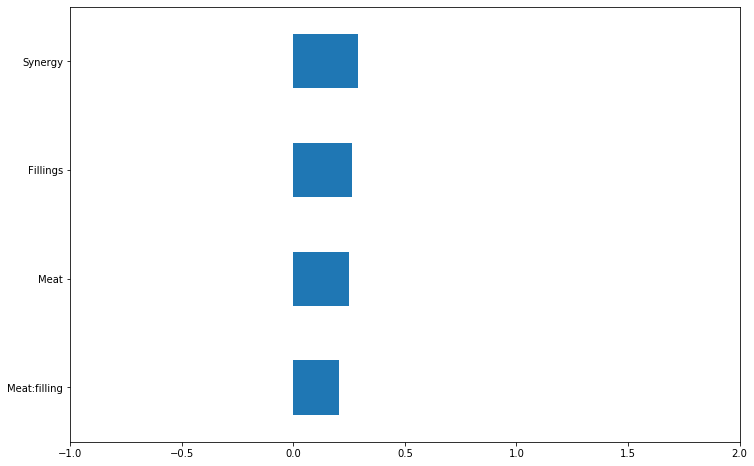

Validation Accuracy: 85.88%


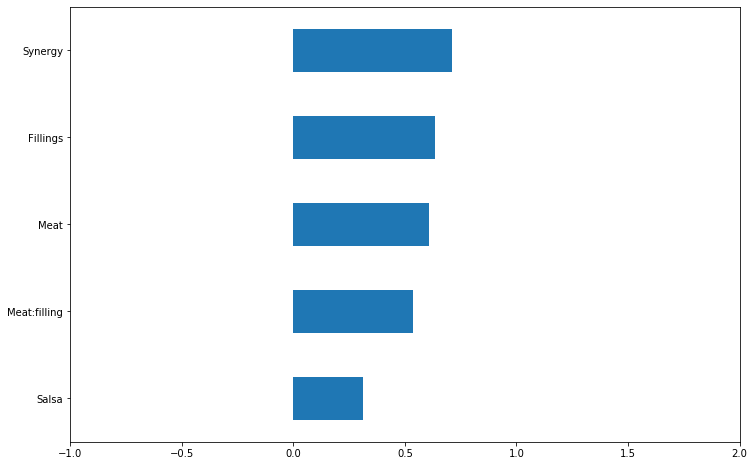

Validation Accuracy: 89.41%


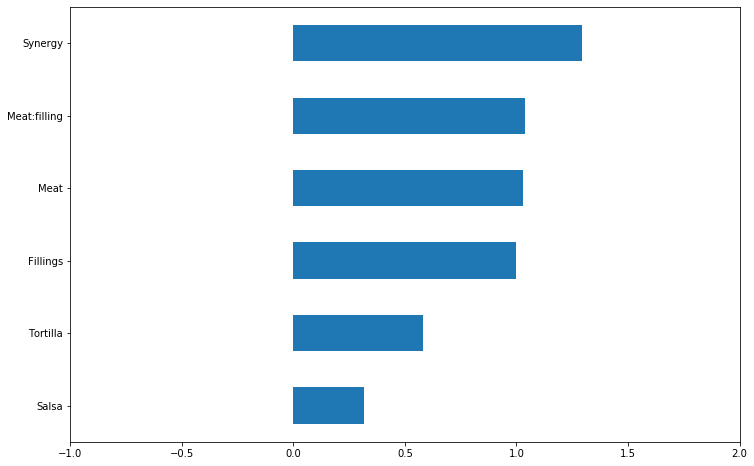

Validation Accuracy: 88.24%


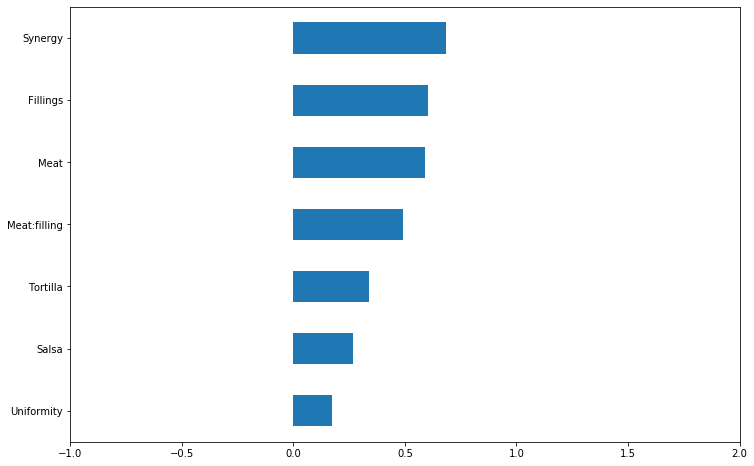

Validation Accuracy: 88.24%


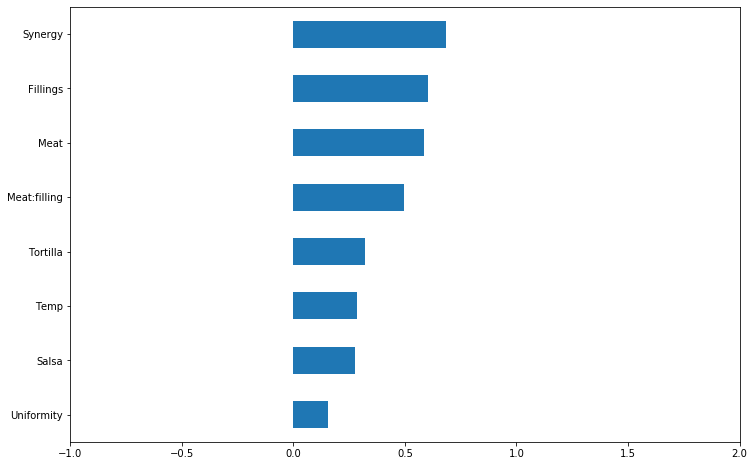

Validation Accuracy: 88.24%


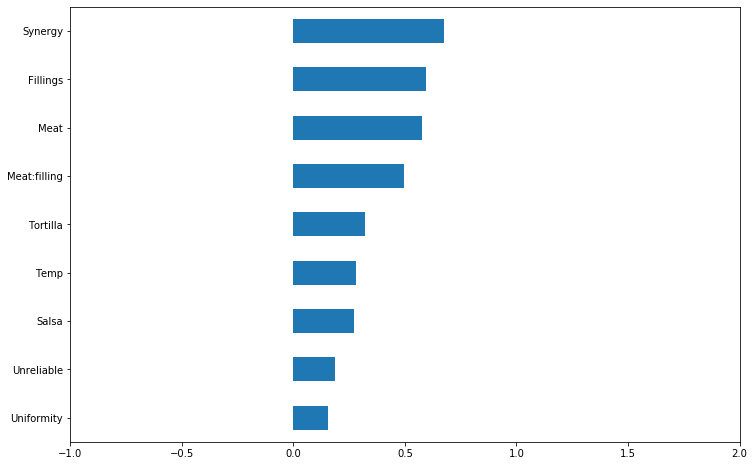

Validation Accuracy: 87.06%


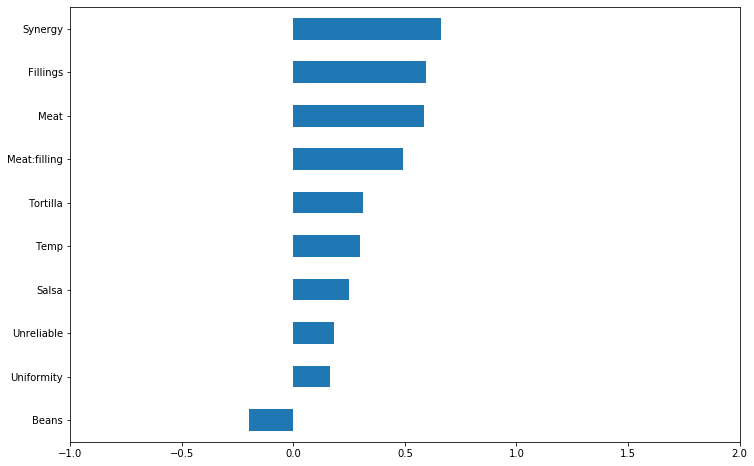

Validation Accuracy: 87.06%


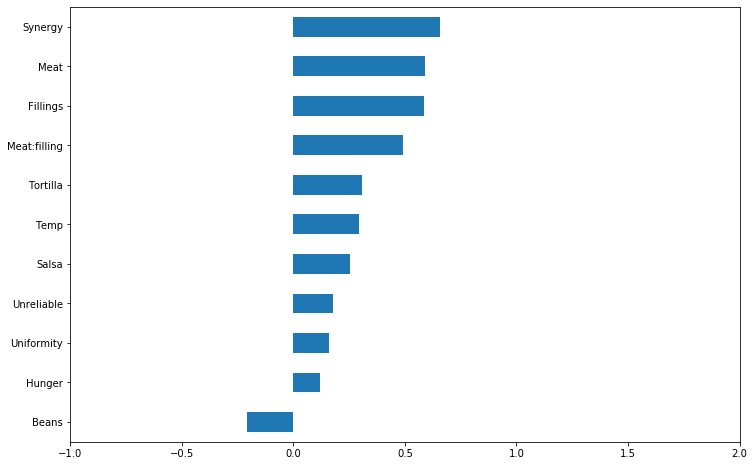

Validation Accuracy: 88.24%


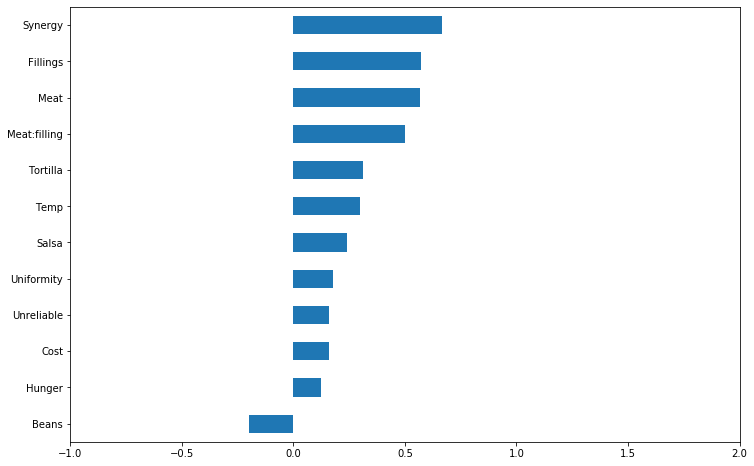

Validation Accuracy: 88.24%


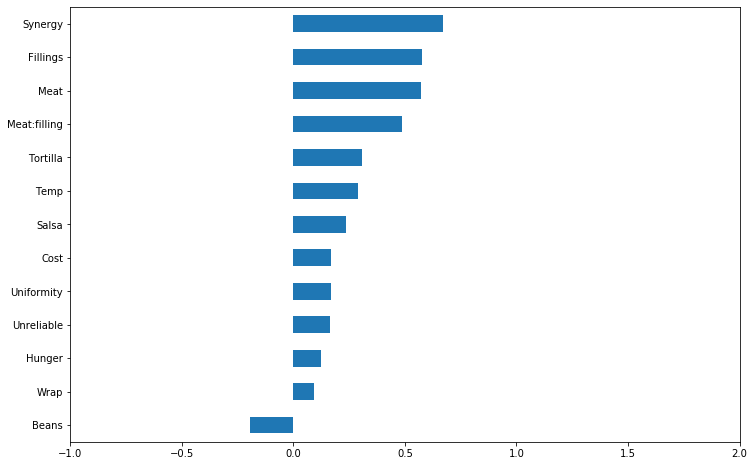

Validation Accuracy: 84.71%


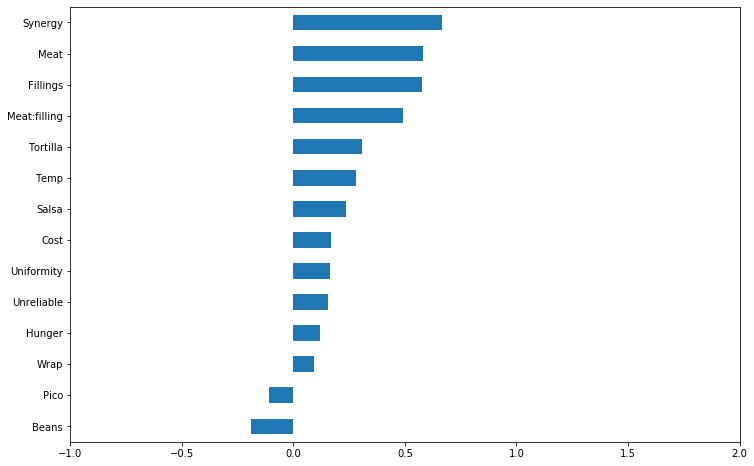

Validation Accuracy: 85.88%


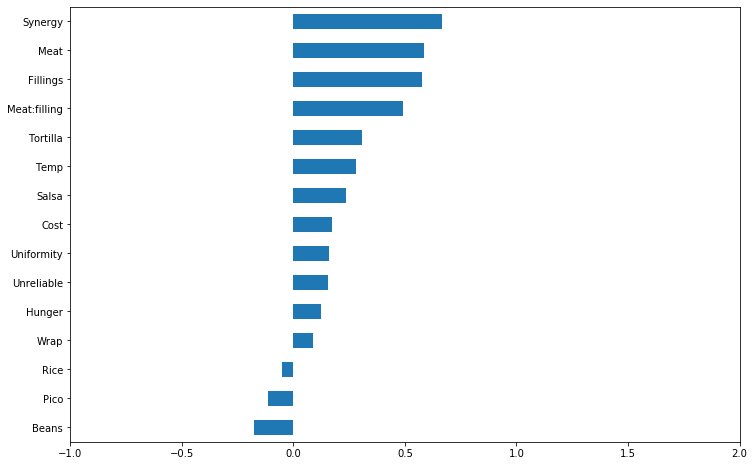

Validation Accuracy: 84.71%


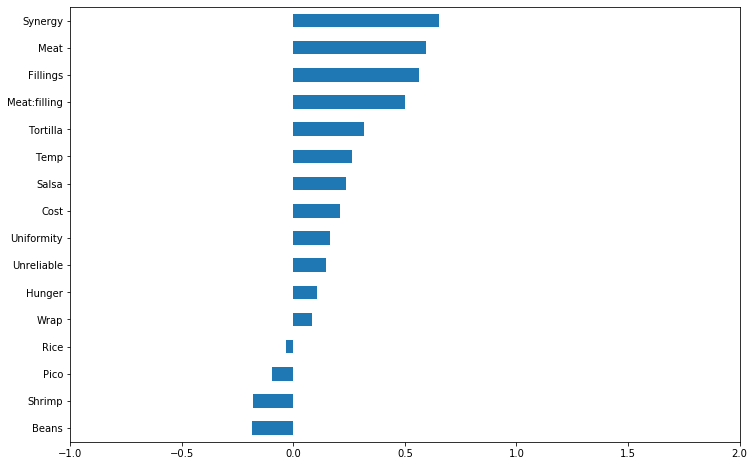

Validation Accuracy: 83.53%


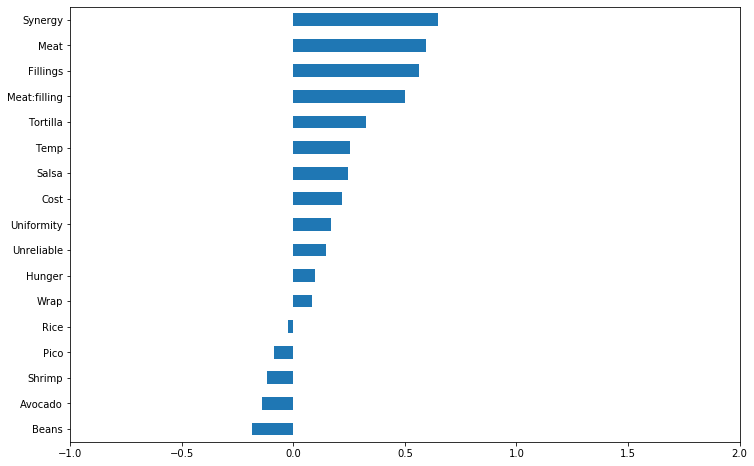

Validation Accuracy: 83.53%


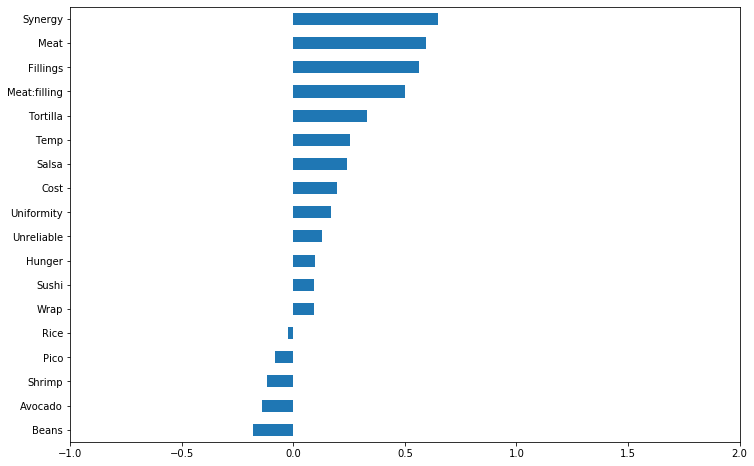

Validation Accuracy: 84.71%


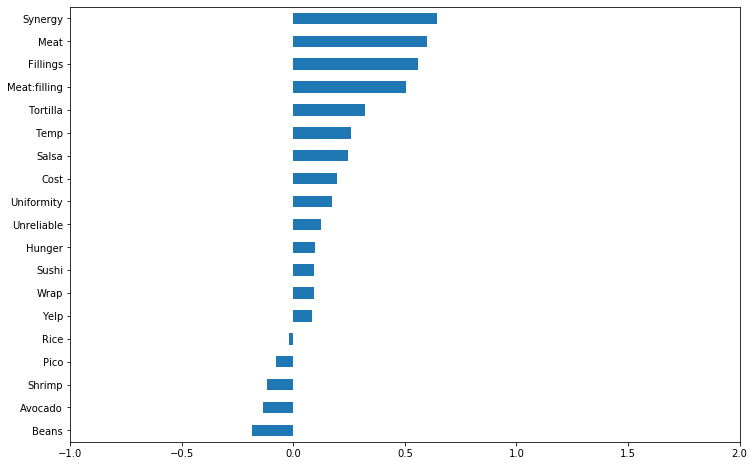

Validation Accuracy: 84.71%


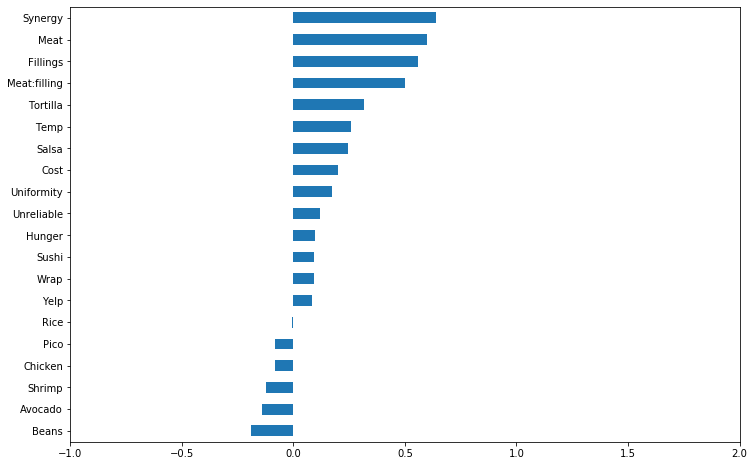

Validation Accuracy: 83.53%


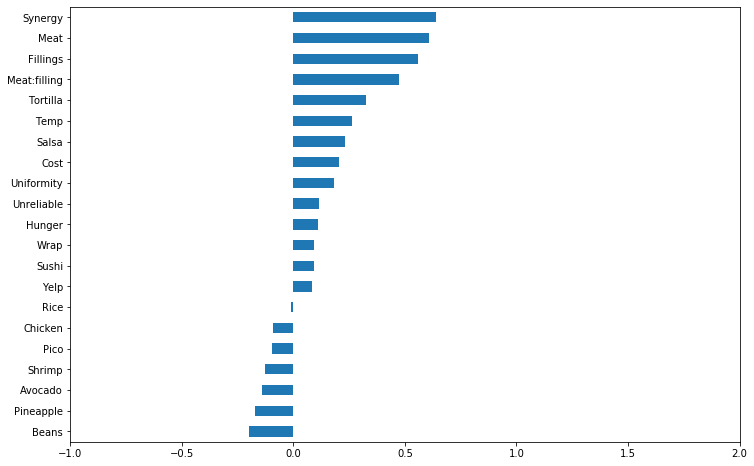

Validation Accuracy: 83.53%


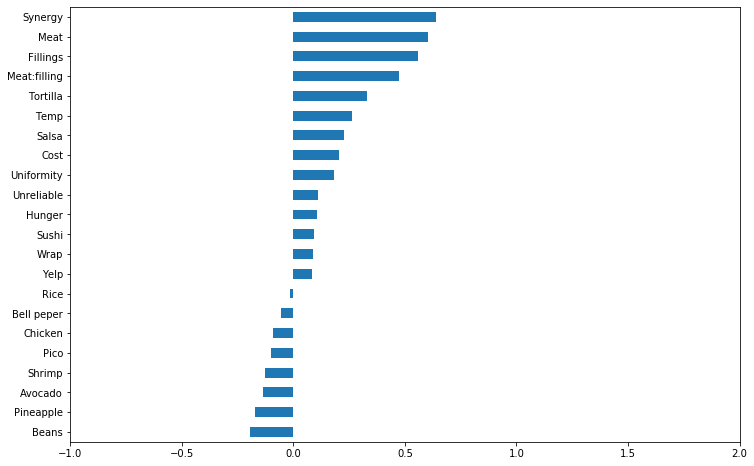

Validation Accuracy: 83.53%


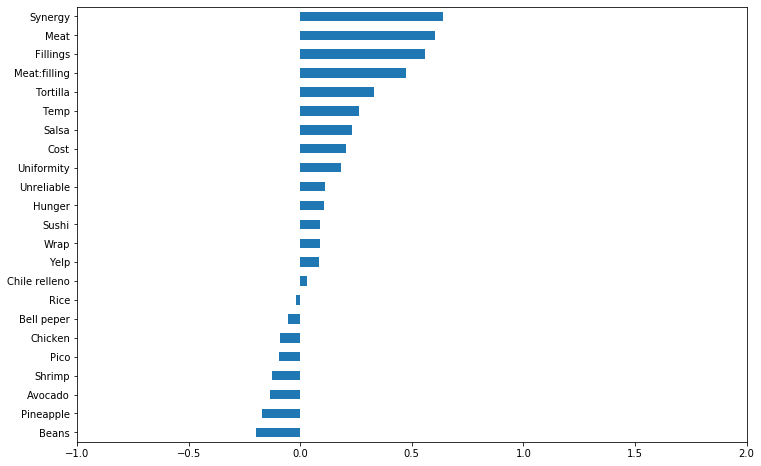

Validation Accuracy: 82.35%


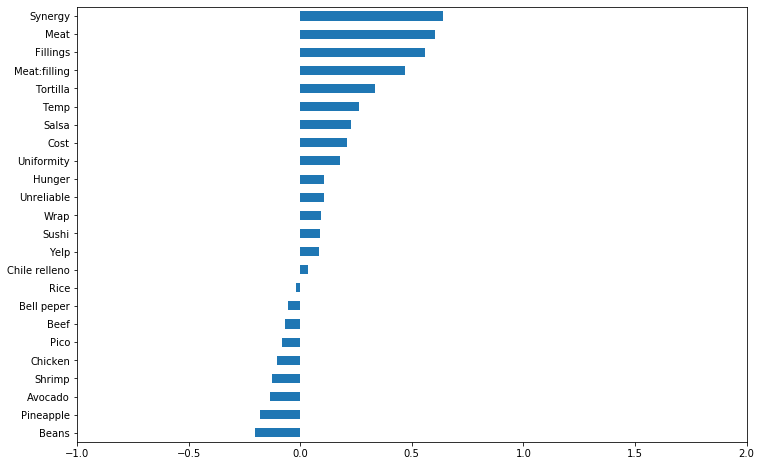

Validation Accuracy: 82.35%


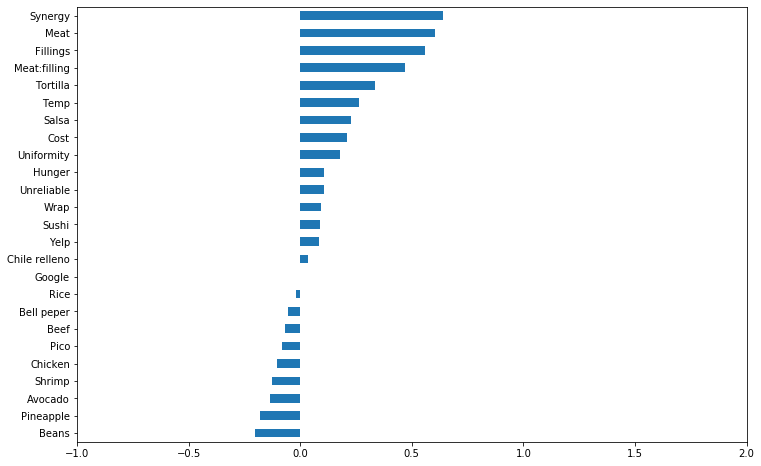

Validation Accuracy: 82.35%


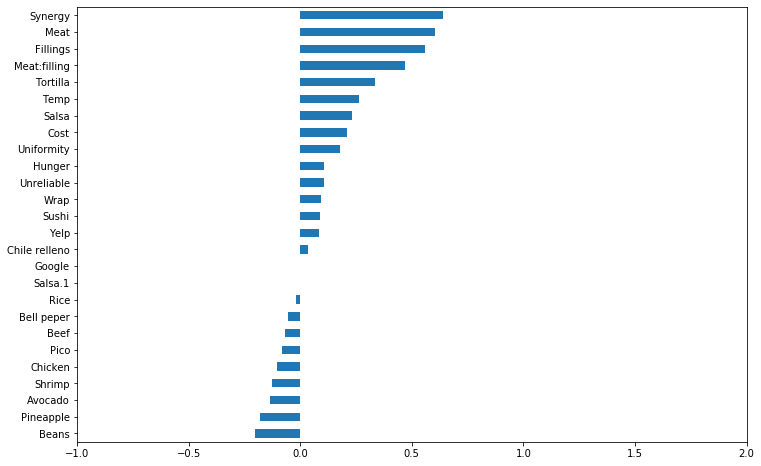

Validation Accuracy: 83.53%


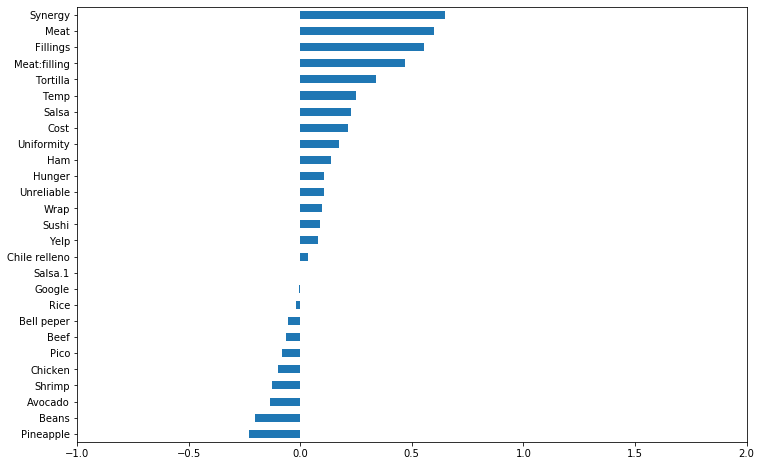

Validation Accuracy: 83.53%


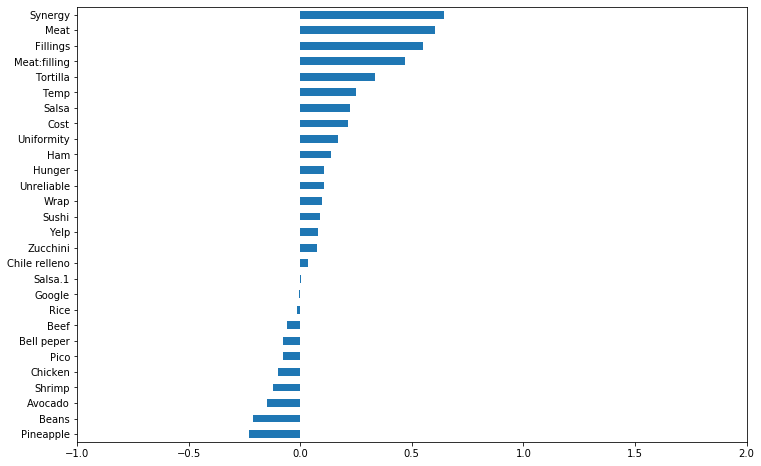

Validation Accuracy: 83.53%


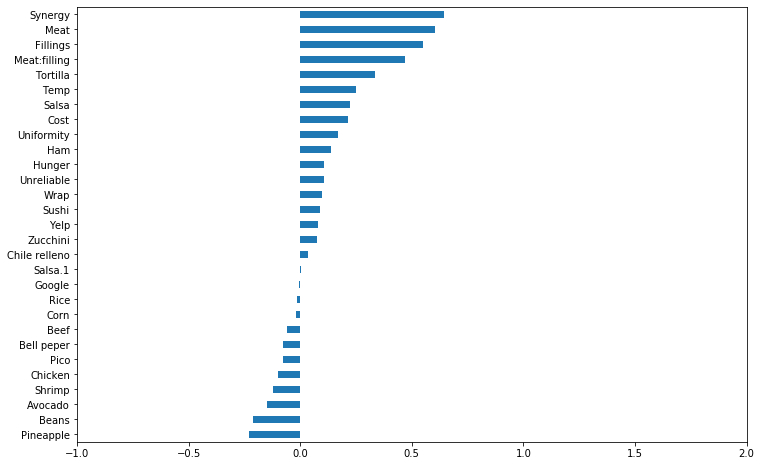

Validation Accuracy: 84.71%


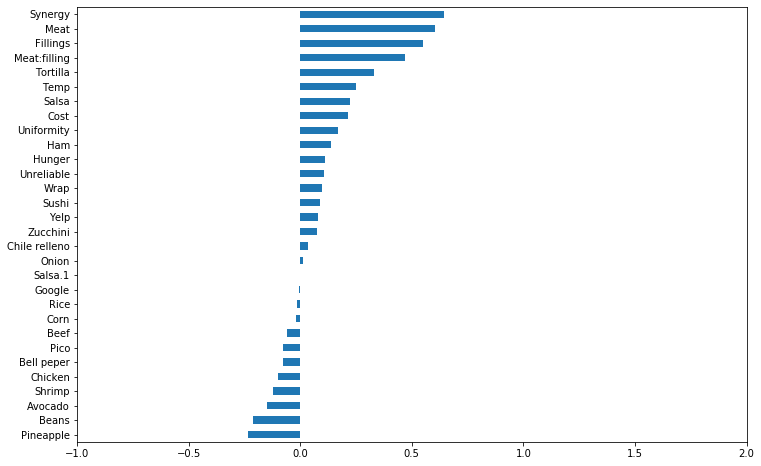

Validation Accuracy: 84.71%


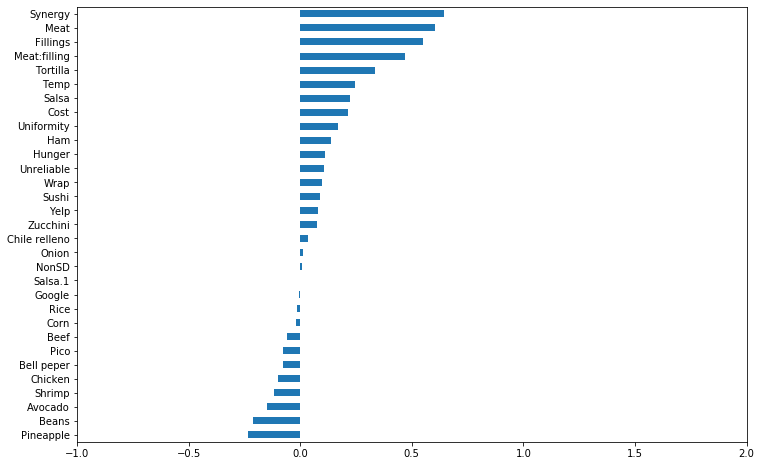

Validation Accuracy: 83.53%


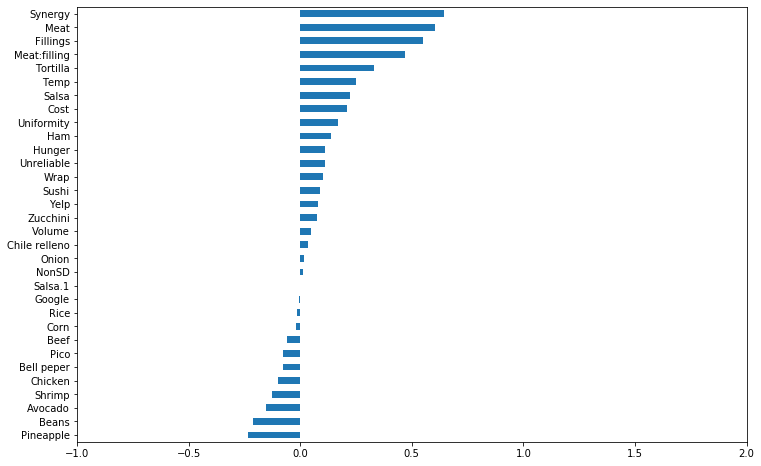

Validation Accuracy: 83.53%


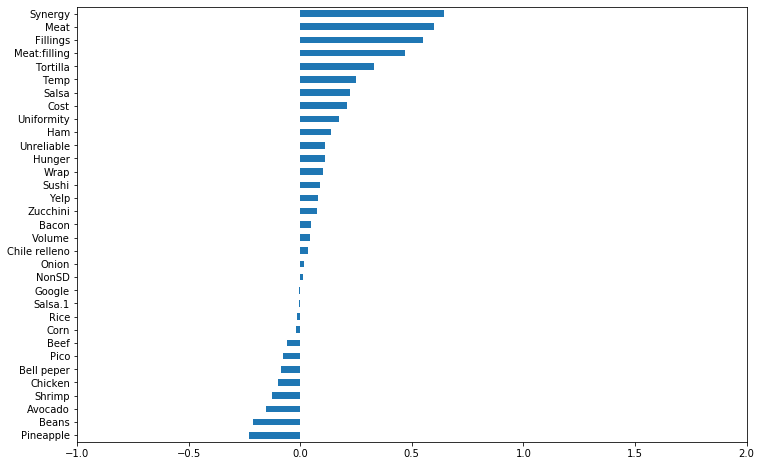

Validation Accuracy: 75.29%


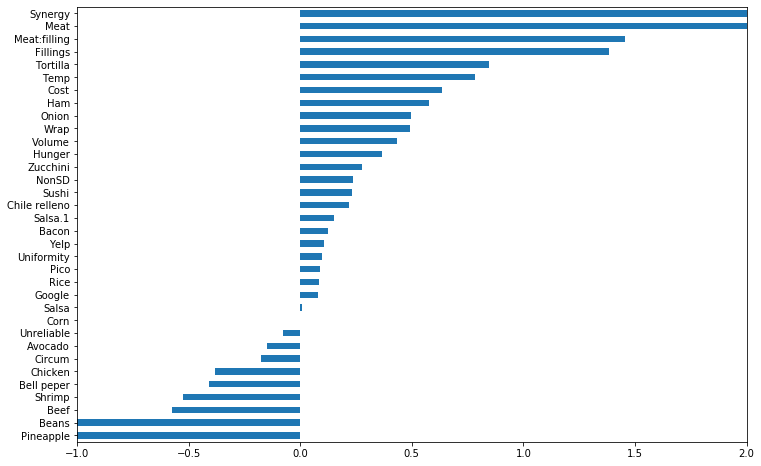

Validation Accuracy: 76.47%


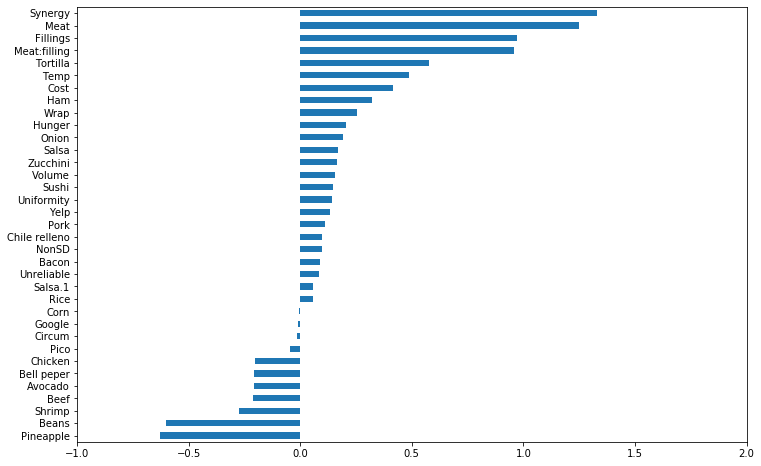

Validation Accuracy: 76.47%


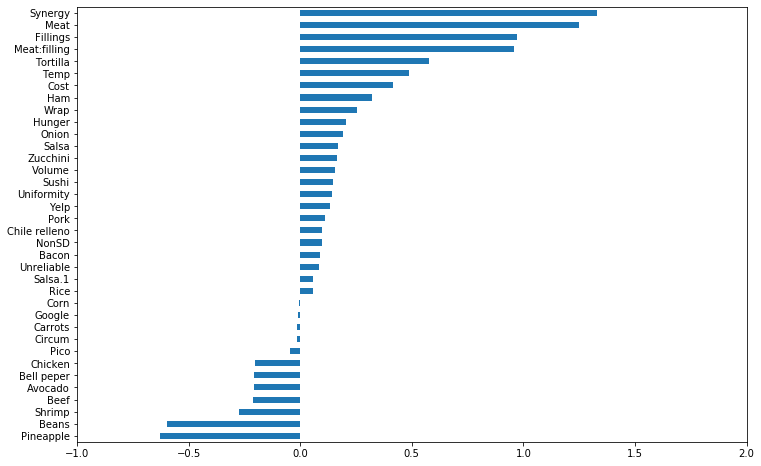

Validation Accuracy: 82.35%


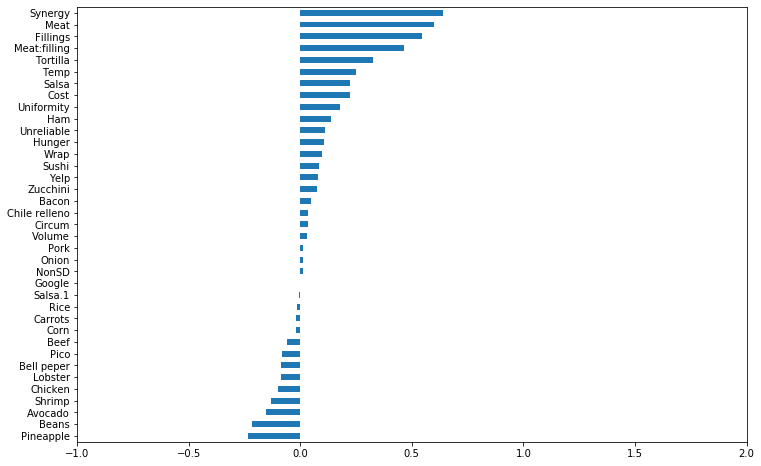

Validation Accuracy: 82.35%


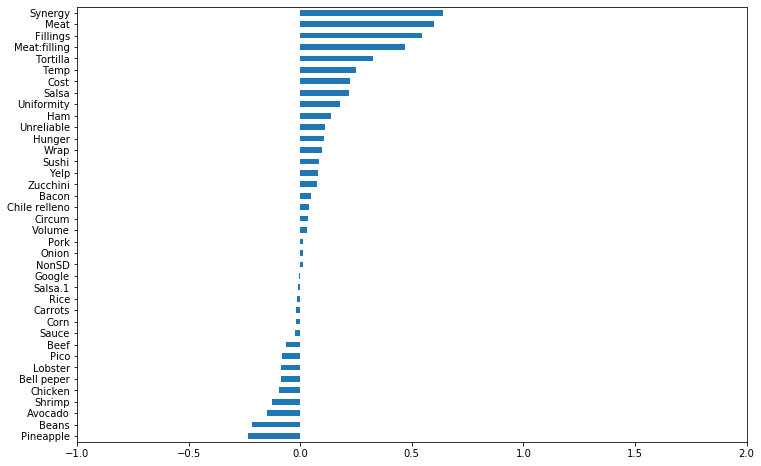

Validation Accuracy: 82.35%


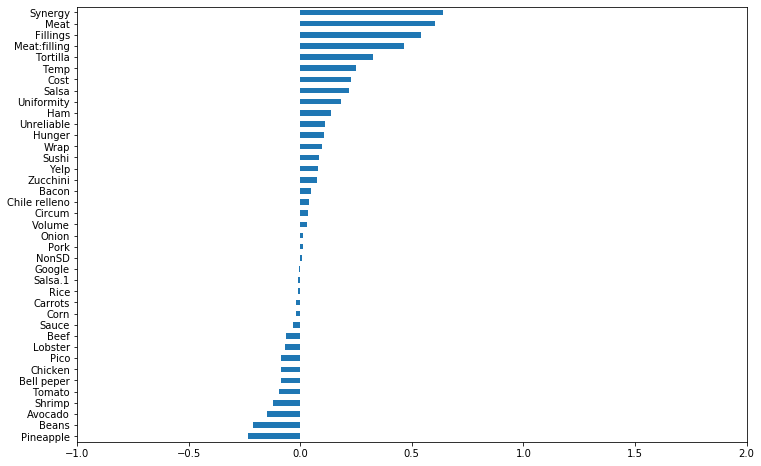

Validation Accuracy: 82.35%


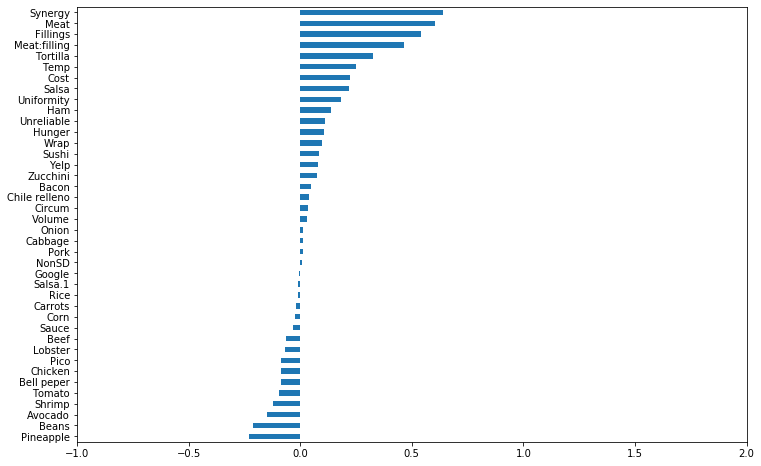

Validation Accuracy: 81.18%


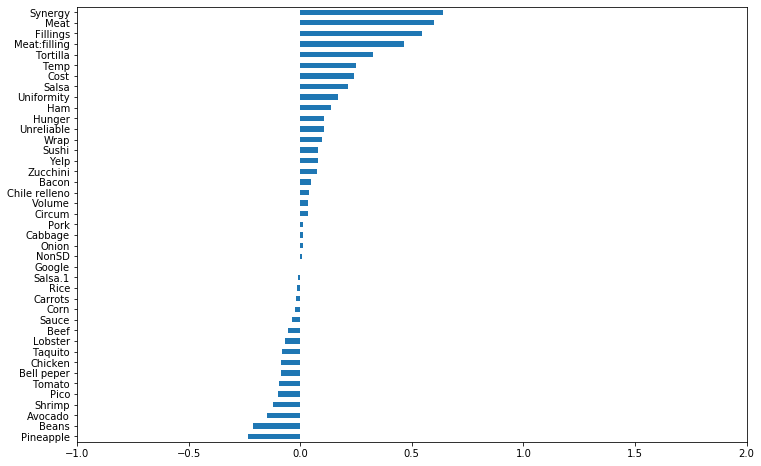

Validation Accuracy: 81.18%


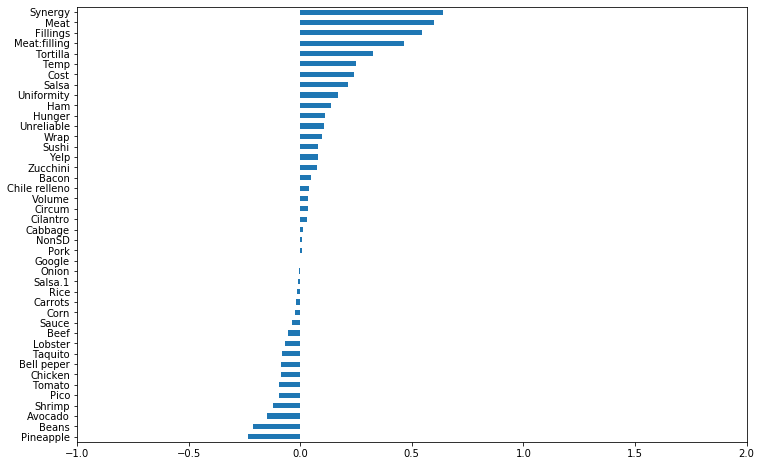

Validation Accuracy: 81.18%


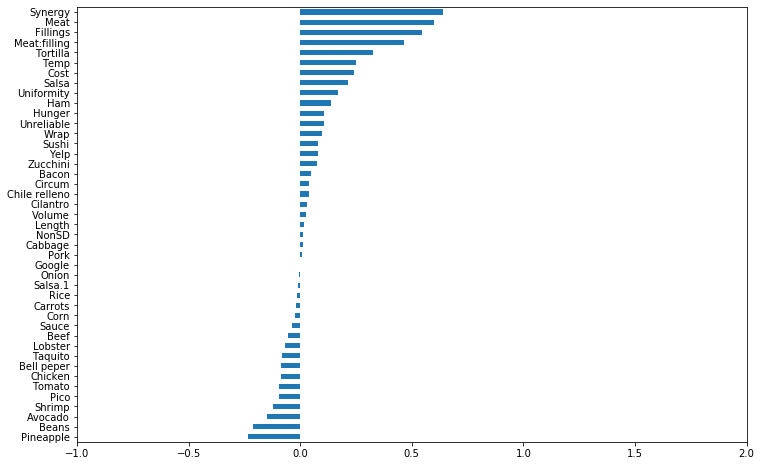

Validation Accuracy: 76.47%


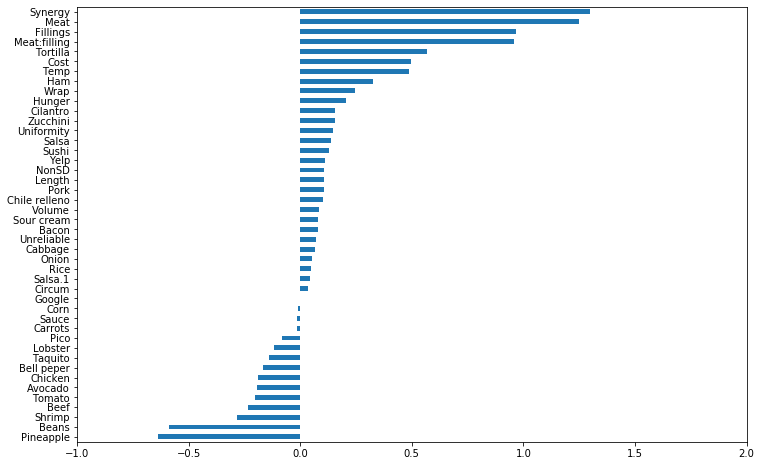

Validation Accuracy: 76.47%


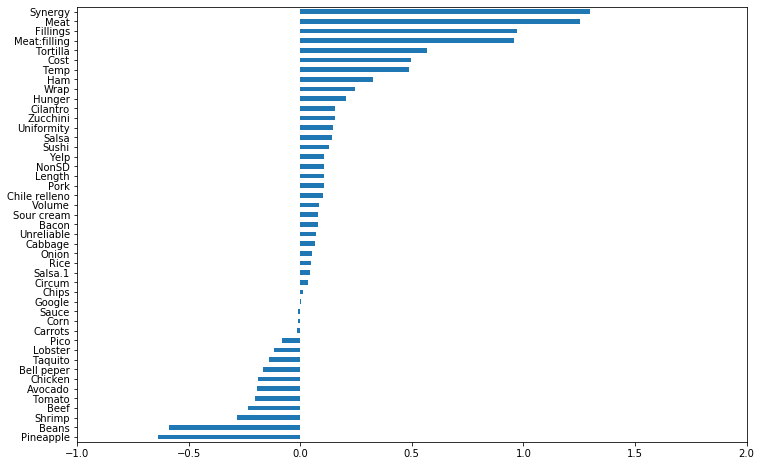

Validation Accuracy: 76.47%


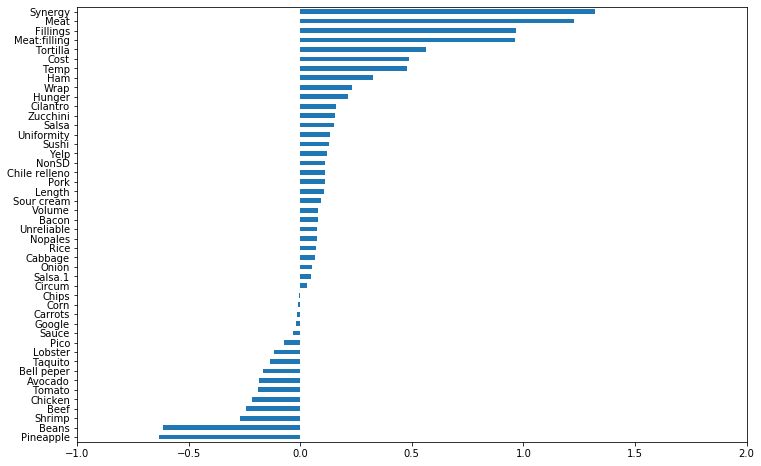

Validation Accuracy: 76.47%


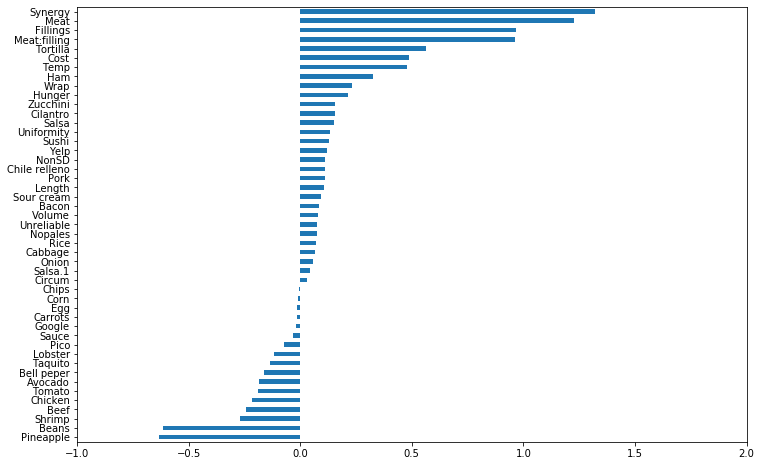

Validation Accuracy: 76.47%


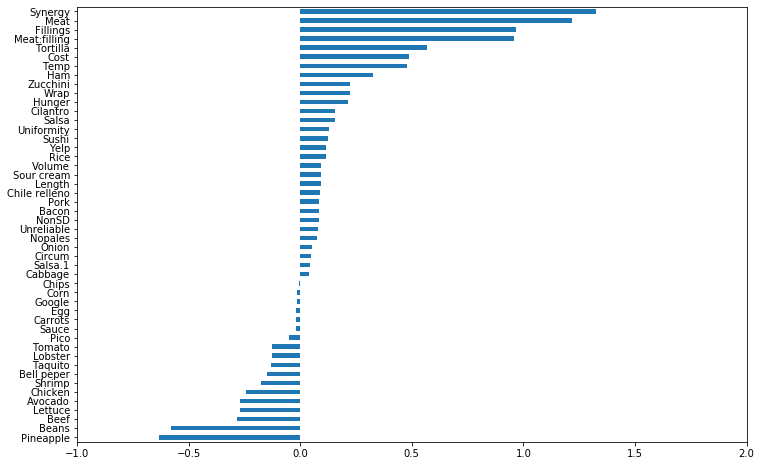

Validation Accuracy: 82.35%


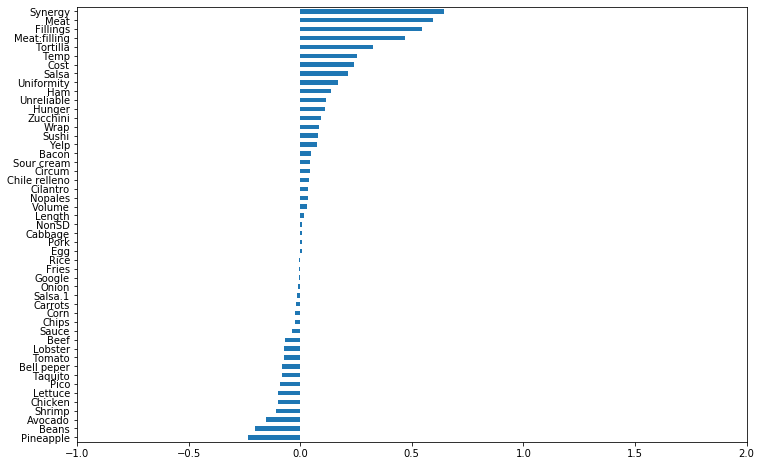

Validation Accuracy: 82.35%


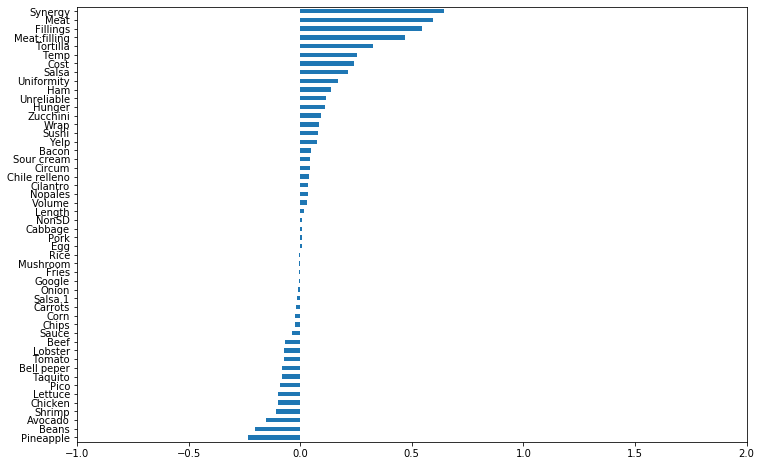

Validation Accuracy: 82.35%


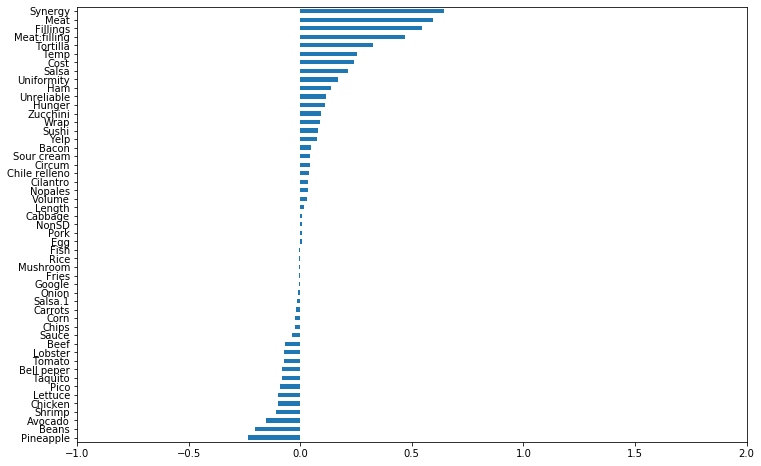

Validation Accuracy: 76.47%


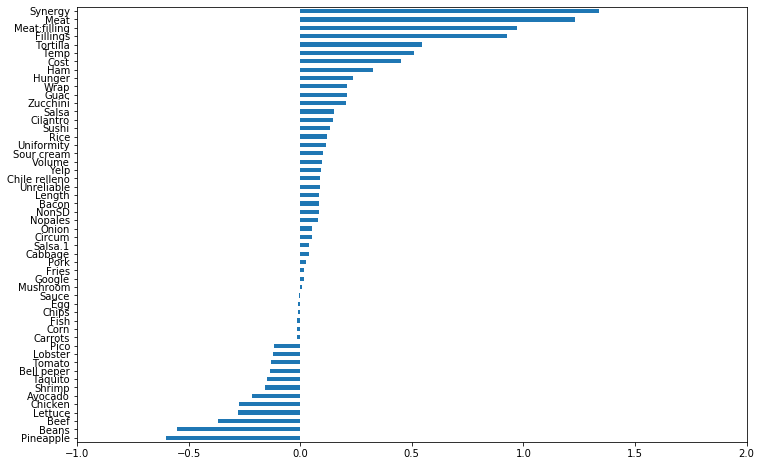

Validation Accuracy: 83.53%


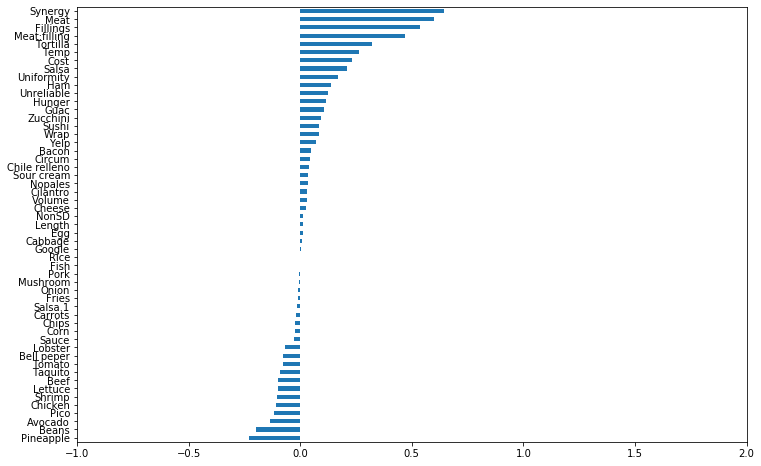

Validation Accuracy: 83.53%


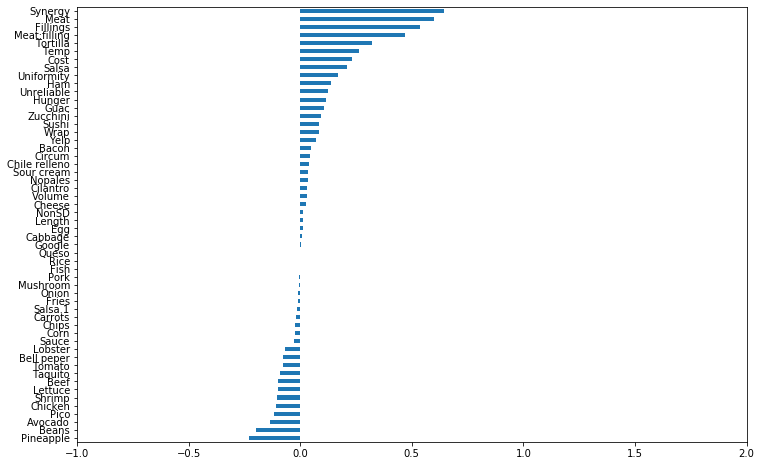

In [203]:
# I'm going to make a bad decision and do feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

for k in range(1, len(X_train.drop(['Mass (g)','Density (g/mL)'], axis=1).columns)+1):
  # Set up selector
  selector = SelectKBest(score_func=f_regression, k=k)

  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_val_selected = selector.transform(X_val_scaled)

  selected_names = X_train.drop(['Mass (g)','Density (g/mL)'], axis=1).columns[selector.get_support()]
  unselected_names = X_train.drop(['Mass (g)','Density (g/mL)'], axis=1).columns[~selector.get_support()]

  # Fit the model
  model = LogisticRegressionCV()
  model.fit(X_train_selected, y_train)

  # Check accuracy of my trained model
  y_pred = model.predict(X_val_selected)
  print(f'Validation Accuracy: {accuracy_score(y_val, y_pred)*100:.2f}%')

  # Show coefficients
  coefficients = pd.Series(model.coef_[0], selected_names)
  plt.figure(figsize=(12,8))
  coefficients.sort_values().plot.barh()
  plt.xlim(-1,2)
  plt.show()

In [213]:
# Three features looks like the best option, with over 90% accuracy

X_test = test[features]
y_test = test[target]

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

selector = SelectKBest(score_func=f_regression, k=3)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Check accuracy of my trained model
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')

Test Accuracy: 72.73%


In [0]:
# Drat.